# Modeling Theta: Muti-population recurrent network (with BMTK BioNet) 

Here we will create a heterogenous yet relatively small network consisting of hundreds of cells recurrently connected. All cells will belong to one of four "cell-types". Two of these cell types will be biophysically detailed cells, i.e. containing a full morphology and somatic and dendritic channels and receptors. The other two will be point-neuron models, which lack a full morphology or channels but still act to provide inhibitory and excitory dynamics.

As input to drive the simulation, we will also create an external network of "virtual cells" that synapse directly onto our internal cells and provide spike trains stimulus

**Note** - scripts and files for running this tutorial can be found in the directory [theta](https://github.com/cyneuro/theta)

requirements:
* bmtk
* NEURON 7.4+

## 1. Building the network

#### cells

This network will loosely resemble the rodent hippocampal CA3 region. Along the center of the column will be a population of 50 biophysically detailed neurons: 40 excitatory Scnn1a cells and 10 inhibitory PV cells.

In [1]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E = 200 # number of RTM excitatory cells
n_I = 50  # number WB inhibitory cells
    

net = NetworkBuilder('network')

net.add_nodes(N=n_I, pop_name='Inh',
        model_type='biophysical',
        model_template='hoc:WBInhCell',
        morphology='blank.swc')

net.add_nodes(N=n_E, pop_name='Exc',
        model_type='biophysical',
        model_template='hoc:RTMExcCell',
        morphology='blank.swc')


To set the position and rotation of each cell, we use the built in function positions_columinar and xiter_random, which returns a list of values given the parameters. A user could set the values themselves using a list (or function that returns a list) of size N. The parameters like location, ei (potential), params_file, etc. are cell-type parameters, and will be used for all N cells of that type.

The excitory cells are also given a tuning_angle parameter. An instrinsic "tuning angle" is a property found in some cells in the visual cortex. In this model, we will use this property to determine number of strenght of connections between subsets of cells by using custom functions. But in general most models will not have or use a tuning angle, but they may require some other parameter. In general, users can assign whatever custom parameters they want to cells and cell-types and use them as properties for creating connections and running simulations.

Next we continue to create our point (integrate-and-fire) neurons. Notice they don't have properities like y/z rotation or morphology, as they wouldn't apply to point neurons.

In [2]:
from bmtk.simulator.bionet.pyfunction_cache import add_synapse_model
from neuron import h
import random


def load_synapses():
    return

load_synapses()

#### connections

Now we want to create connections between the cells. Depending on the model type, and whether or not the presynpatic "source" cell is excitory or inhibitory, we will have different synpatic model and parameters. Using the source and target filter parameters, we can create different connection types.

To determine excitory-to-excitory connection matrix we want to use distance and tuning_angle property. To do this we create a customized function "dist_tuning_connector"

In [3]:
import random

def syn_connector(source,target,prob):
    return 1 if random.random() < prob else 0

This first two parameters of this function is "source" and "target" and are required for all custom connector functions. These are node objects which gives a representation of a single source and target cell, with properties that can be accessed like a python dictionary. When The Network Builder is creating the connection matrix, it will call this function for all possible source-target pairs. The user doesn't call this function directly.

The remaining parameters are optional. Using these parameters, plus the distance and angles between source and target cells, this function determines the number of connections between each given source and target cell. If there are none you can return either None or 0.

To create these connections we call add_edges method of the builder. We use the source and target parameter to filter out only excitory-to-excitory connections. We must also take into consideration the model type (biophysical or integrate-and-fire) of the target when setting parameters. We pass in the function throught the connection_rule parameter, and the function parameters (except source and target) through connection_params. (If our dist_tuning_connector function didn't have any parameters other than source and target, we could just not set connection_params).

In [4]:
p_EE = 0.0 # Probability of Excitatory RTM Cells Connecting to Excitatory RTM Cells
p_EI = 1 #0.5 # Probability of Excitatory RTM Cells Connecting to Inhibitory WB Cells
p_IE = 1 #0.5 # Probability of Inhibitory WB Cells Cells Connecting to Excitatory RTM Cells
p_II = 1 #0.5 # Probability of Inhibitory WB Cells Cells Connecting to Inhibitory WB Cells

g_hat_EE = 0
g_hat_EI = 1.25 #0.25
g_hat_IE = 1.25 #0.25
g_hat_II = 0.4  #0.25

conn = net.add_edges(source={'pop_name':'Exc'}, target={'pop_name':'Inh'},
            connection_rule=syn_connector,
            connection_params={'prob':p_EI},
            syn_weight=g_hat_EI/n_E, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='PING_ExcToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])


Similarly we create the other types of connections. But since either the source, target, or both cells will not have the tuning_angle parameter, we don't want to use dist_tuning_connector. Instead we can use the built-in distance_connector function which just creates connections determined by distance.

In [5]:

conn = net.add_edges(source={'pop_name':'Inh'}, target={'pop_name':'Exc'},
            connection_rule=syn_connector,
            connection_params={'prob':p_IE},
            syn_weight=g_hat_IE/n_I, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='PING_InhToExc.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])


conn = net.add_edges(source={'pop_name':'Inh'}, target={'pop_name':'Inh'},
            connection_rule=syn_connector,
            connection_params={'prob':p_II},
            syn_weight=g_hat_II/n_I, # Synaptic weight is g^ over the total number of cell in the population
            dynamics_params='PING_InhToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            delay=0,
            target_sections=['soma'])



Finally we build the network (this may take a bit of time since it's essentially iterating over all 400x400 possible connection combinations), and save the nodes and edges.

In [6]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Building external network

Next we want to create an external network consisting of virtual cells that form a feedforward network onto our V1, which will provide input during the simulation. We will call this LGN, since the LGN is the primary input the layer 4 cells of the V1 (if we wanted to we could also create multiple external networks and run simulations on any number of them). 

First we build our LGN nodes. Then we must import the V1 network nodes, and create connections between LGN --> V1.

In [7]:
from bmtk.builder.networks import NetworkBuilder

extnet = NetworkBuilder('extnet')

extnet.add_nodes(N=n_E, model_type='virtual', pop_name='bgnoisevirtExt', pop_group='bgnoisevirtExt')


As before, we will use a customized function to determine the number of connections between each source and target pair, however this time our connection_rule is a bit different

In the previous example, our connection_rule function's first two arguments were the presynaptic and postsynaptic cells, which allowed us to choose how many synaptic connections between the pairs existed based on individual properties:
```python
def connection_fnc(source, target, ...):
    source['param'] # presynaptic cell params
    target['param'] # postsynaptic cell params
    ...
    return nsyns # number of connections between pair
```

But for our LGN --> V1 connection, we do things a bit differently. We want to make sure that for every source cell, there are a limited number of presynaptic targets. This is a not really possible with a function that iterates on a one-to-one basis. So instead we have a connector function who's first parameter is a list of all N source cell, and the second parameter is a single target cell. We return an array of integers, size N; which each index representing the number of synaptics between sources and the target. 

To tell the builder to use this schema, we must set iterator='all_to_one' in the add_edges method. (By default this is set to 'one_to_one'. You can also use 'one_to_all' iterator which will pass in a single source and all possible targets).

In [8]:
def target_ind_equals_source_ind(source, targets, offset=0, min_syn=1,max_syn=1):
    # Creates a 1 to 1 mapping between source and destination nodes
    total_targets = len(targets)
    syns = np.zeros(total_targets)
    target_index = source['node_id']
    syns[target_index-offset] = 1
    return syns
        

g_bar_stoch = 0.03
    
conn = extnet.add_edges(target=net.nodes(pop_name='Exc'),
            source={'pop_name':'bgnoisevirtExt'},
            iterator='one_to_all',
            connection_rule=target_ind_equals_source_ind,
            connection_params={'offset':n_I},
            dynamics_params='PING_ExcToInh.json',
            model_template='exp2syn',
            distance_range=[0.0,999.9],
            target_sections=['soma'],
            delay=0,
            syn_weight=g_bar_stoch
            )

extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

## 2. Setting up BioNet

#### file structure.

Before running a simulation, we will need to create the runtime environment, including parameter files, run-script and configuration files. You can copy the files from an existing simuatlion, execute the following command:

```bash
$ python -m bmtk.utils.sim_setup  \
   --network network              \
   --dt 0.1                       \
   --tstop 1000.0                 \
   bionet .
```

$ python -m bmtk.utils.sim_setup --network network --dt 0.1 --tstop 1000.0 bionet .

or run it directly in python

In [9]:
from bmtk.utils.sim_setup import build_env_bionet

sim_len = 1000.0
dt = 0.1

# This step has already been performed for you. 
# Running again will remove customized configuration files. 
# If you wish to run again, remove comment tags below.

#build_env_bionet(base_dir='.',      
#                 network_dir='network',
#                 tstop=sim_len, dt=dt
#                )


This will fill out the **sim_ch04** with all the files we need to get started to run the simulation. Of interest includes

* **circuit_config.json** - A configuration file that contains the location of the network files we created above. Plus location of neuron and synpatic models, templates, morphologies and mechanisms required to build our instantiate individual cell models.


* **simulation_config.json** - contains information about the simulation. Including initial conditions and run-time configuration (_run_ and _conditions_). In the _inputs_ section we define what external sources we will use to drive the network (in this case a current clamp). And in the _reports_ section we define the variables (soma membrane potential and calcium) that will be recorded during the simulation 


* **run_bionent.py** - A script for running our simulation. Usually this file doesn't need to be modified.


* **components/biophysical_neuron_models/** - The parameter file for the cells we're modeling. Originally [downloaded from the Allen Cell Types Database](http://celltypes.brain-map.org/neuronal_model/download/482934212). These files were automatically copies over when we used the _include-examples_ directive. If using a differrent or extended set of cell models place them here


* **components/biophysical_neuron_models/** - The morphology file for our cells. Originally [downloaded from the Allen Cell Types Database](http://celltypes.brain-map.org/neuronal_model/download/482934212) and copied over using the _include_examples_.


* **components/point_neuron_models/** - The parameter file for our LIF_exc and LIF_inh cells.


* **components/synaptic_models/** - Parameter files used to create different types of synapses.


#### circuit_config.json
The `circuit_config.json` file will need to be modified to specify our network configuration files generated previously. Your `"networks"` section should look like the following:

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/network_nodes.h5",
        "node_types_file": "$NETWORK_DIR/network_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/extnet_nodes.h5",
        "node_types_file": "$NETWORK_DIR/extnet_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/network_network_edges.h5",
        "edge_types_file": "$NETWORK_DIR/network_network_edge_types.csv" 
      },
      {
        "edges_file": "$NETWORK_DIR/extnet_network_edges.h5",
        "edge_types_file": "$NETWORK_DIR/extnet_network_edge_types.csv" 
      }
    ],
    "gap_juncs": []
  }
```

#### lgn input

We need to provide our LGN external network cells with spike-trains so they can activate our recurrent network. Previously we showed how to do this by generating csv files. We can also use NWB files, which are a common format for saving electrophysiological data in neuroscience.

We can use any NWB file generated experimentally or computationally, but for this example we will use a preexsting one. First download the file:
```bash
 $ wget https://github.com/AllenInstitute/bmtk/blob/develop/docs/examples/spikes_inputs/lgn_spikes.nwb?raw=true
```
or copy from [here](https://github.com/AllenInstitute/bmtk/tree/develop/docs/examples/spikes_inputs/lgn_spikes.nwb).


Then we must edit the **simulation_config.json** file to tell the simulator to find the nwb file and which network to associate it with. **This has already been done for you**

```json
{
  "node_sets": {
    "Exc": {
      "pop_name":"Exc"
    }
  },
  "inputs": {
    "rtm_spikes": {
      "input_type": "spikes",
      "module": "h5",
      "input_file": "$BASE_DIR/input/ext_inp_poisson.h5",
      "node_set": "Exc"
    }
  }
}
```


In [10]:
def generate_ext_poisson_input(n_E,freq=60,offset=0,population='extnet',times=(0.0, 1.0),filename='input/ext_inp_poisson.h5'):
    '''
    Generate poisson input for ext cells
    '''
    import os
    from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
    
    try:
        os.remove(filename)
    except OSError:
        pass
    
    psg = PoissonSpikeGenerator(population=population)
    psg.add(node_ids=range(offset,offset+n_E),  # Select nodes
            firing_rate=freq,     # 'freq' Hz, we can also pass in a nonhomoegenous function/array
            times=times)    # Firing starts at 0 s up to 1 s by default
    psg.to_sonata(filename)
    logging.info(filename + " written")


#n_E defined above
stoch_freq = 60

generate_ext_poisson_input(n_E,freq=stoch_freq,filename='input/ext_inp_poisson.h5')

Now we need to generate a constant current drive for both RTM and WB cells.

In [11]:
import h5py

I_bar_E = 0.6 #1.4 
sigma_E = 0.0 #0.05
I_bar_I = 0.6 #0.0
sigma_I = 0.0

samples = int(sim_len/dt)
amp = np.zeros((n_E+n_I,samples))

#amp[:n_E,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
#amp[n_E:,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection

amp[n_I:,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
amp[:n_I,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[amp])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Cell definitions
Now that we know what our network will look like we need to define our cells. The cells used here are RTM and WB that follow the formulation:

Template hoc files should be defined in `templates.hoc` and placed in the `components/templates` directory. The contents are shown below:

```C++
begintemplate WBInhCell
	public soma	// declares object soma is a public object that can be accessed by any procedures/functions
	create soma	// declares soma as a membrane compartment object

	proc init() {

    	create soma	// create soma in the initialization

		/////// geometrical properties //////
		soma {
			nseg=1	// create only one segment in the soma
	    	}

		/////// biophysical properties //////
		soma {
			cm = 1		// (microF/cm2)
			// gives leak conductance of .03 mS/cm2
			insert leak
			eleak = -65 // (mV)
			gbar_leak = .1e-3 // (siemens/cm2)
			
			/////////////////////////////////////////////////////////////////////////
			// Use insert command to insert more channels here

			///Spiking
			insert na_wb
			ena = 55
			gbar_na_wb = .035 // (siemens/cm2)

			insert k_wb
			ek = -90
			gbar_k_wb = .009 // (siemens/cm2)
			

			/////////////////////////////////////////////////////////////////////////
		}
	}
endtemplate WBInhCell


begintemplate RTMExcCell
	public soma	// declares object soma is a public object that can be accessed by any procedures/functions
	create soma	// declares soma as a membrane compartment object

	proc init() {

    	create soma	// create soma in the initialization

		/////// geometrical properties //////
		soma {
			nseg=1	// create only one segment in the soma
			//L=1.492		// (micrometer)
			//diam=1	// (micrometer)
	    	}

		/////// biophysical properties //////
		soma {
			cm = 1		// (microF/cm2)
			// gives leak conductance of .03 mS/cm2
			insert leak
			eleak = -67 // (mV)
			gbar_leak = .1e-3 // (siemens/cm2)
			
			/////////////////////////////////////////////////////////////////////////
			// Use insert command to insert more channels here

			///Spiking
			insert na_rtm
			ena = 50
			gbar_na_rtm = .1 // (siemens/cm2)

			insert k_rtm
			ek = -100
			gbar_k_rtm = .08 // (siemens/cm2)
			

			/////////////////////////////////////////////////////////////////////////
		}
	}
endtemplate RTMExcCell
```

### Current Channels
Mod files for the sodium, potassium and leak channels are defined in the `components/mechanisms` folder. The RTM Sodium channel contents of `components/mechanisms/na_rtm.mod` are shown below. See the additional `k_rtm.mod`, `na_wb.mod`, `k_wb.mod`, and `leak.mod` files in the same directory.

```c
COMMENT
Reduced Traub-Miles Model of a Pyramidal
Neuron in Rat Hippocampus

Sodium Channel

Reference: Borgers - An Introduction to Modeling Neuronal Dynamics Chapter 5
.mod by Tyler Banks
ENDCOMMENT

NEURON {
	SUFFIX na_rtm
	USEION na READ ena WRITE ina
	RANGE gbar, g
	RANGE minf, hinf, mtau, htau
	RANGE ina
    RANGE minfvhalf,minfk,hinfvhalf,hinfk
}

UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
}

PARAMETER {
	gbar (siemens/cm2)
    minfvhalf = 41.03
    minfk = -7.1 :-7.41
    hinfvhalf = 45.32
    hinfk = 4.04
}

ASSIGNED {
	v (mV)
	ena (mV)
	ina (mA/cm2)
	minf
	hinf
	mtau (ms)
	htau (ms)
	g (siemens/cm2)
}

STATE {
	m h
}

BREAKPOINT {
	SOLVE states METHOD cnexp
	m = minf : See Borgers Page 32 Figure 5.1 for explaination
	g = gbar*m*m*m*h
	ina = g*(v-ena)
}

INITIAL {
	rate(v)
	m = minf
	h = hinf
}

DERIVATIVE states {
	rate(v)
	:m' = (minf-m)/mtau
	h' = (hinf-h)/htau
}

PROCEDURE rate(v (mV)) {
	UNITSOFF
	minf = 1.0/(1.0+(exp((v+minfvhalf)/(minfk))))
	mtau = (1 - exp(-v/4 - 27/2))*(1 - exp(v/5 + 27/5))/(-(1 - exp(-v/4 - 27/2))*(0.28*v + 7.56) + (1 - exp(v/5 + 27/5))*(0.32*v + 17.28))

	hinf = 1.0/(1.0+(exp((v+hinfvhalf)/(hinfk))))
	htau = (exp(-v/5 - 27/5) + 1)/(0.128*(exp(-v/5 - 27/5) + 1)*exp(-v/18 - 25/9) + 4)
	UNITSON
}
```

#### Synapse properties

Properties for synapses will be located in the `components/synaptic_models` directory. We'll need `PING_ExcToInh.json` for excitatory to inhibitory, `PING_InhToExc.json` for inhibitory to excitatory, and `PING_InhToInh.json` for inhibitory to inhibitory connections. An example of one is shown below. Edit these files before running the simulation to test different synaptic parameters.

```json
{
    "tau1": "0.5",
    "tau2": "3",
    "erev": "0"
}
```


## 3. Running the simulation


We are close to running our simulation, however unlike in previous chapters we need a little more programming before we can begin. 

For most of the connections we added the parameter weight_function='wmax'. This is a built-in function that tells the simulator when creating a connection between two cells, just use the 'weight_max' value assigned to that given edge-type. 

However, when creating excitatory-to-excitatory connections we used weight_function='gaussianLL'. This is because we want to use the tuning_angle parameter, when avaiable, to determine the synaptic strength between two connections. First we create the function which takes in target, source and connection properties (which are just the edge-type and properties set in the add_edges method). Then we must register the function with the BioNet simulator:

In [12]:
import math
from bmtk.simulator.bionet.pyfunction_cache import add_weight_function

def gaussianLL(edge_props, source, target):
    src_tuning = source['tuning_angle']
    tar_tuning = target['tuning_angle']
    w0 = edge_props["syn_weight"]
    sigma = edge_props["weight_sigma"]

    delta_tuning = abs(abs(abs(180.0 - abs(float(tar_tuning) - float(src_tuning)) % 360.0) - 90.0) - 90.0)
    return w0 * math.exp(-(delta_tuning / sigma) ** 2)

add_weight_function(gaussianLL)

The weights will be adjusted before each simulation, and the function can be changed between different runs.. Simply opening the edge_types.csv file with a text editor and altering the weight_function column allows users to take an existing network and readjust weights on-the-fly.

Finally we are ready to run the simulation. Note that because this is a 400 cell simulation, this may be computationally intensive for some older computers and may take anywhere between a few minutes to half-an-hour to complete.

In [13]:
from bmtk.simulator import bionet
from bmtk.simulator.bionet.default_setters.cell_models import loadHOC
#This is not needed in newer versions of BMTK
bionet.pyfunction_cache.add_cell_model(loadHOC, directive='hoc', model_type='biophysical')

conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2020-10-16 04:22:52,124 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2020-10-16 04:22:52,271 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2020-10-16 04:22:52,621 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2020-10-16 04:23:30,995 [INFO] Building virtual cell stimulations for noise


INFO:NEURONIOUtils:Building virtual cell stimulations for noise


2020-10-16 04:23:32,695 [INFO] Running simulation for 1000.000 ms with the time step 0.100 ms


/home/tjbanks/temp/bmtk/bmtk/simulator/bionet/biosimulator.py:226: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if "gids" not in list(file.keys()) or file["gids"].value == 'all':
/home/tjbanks/temp/bmtk/bmtk/simulator/bionet/biosimulator.py:240: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  amplitudes = file["amplitudes"].value
/home/tjbanks/temp/bmtk/bmtk/simulator/bionet/biosimulator.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dts = file["dts"].value
INFO:NEURONIOUtils:Running simulation for 1000.000 ms with the time step 0.100 ms


2020-10-16 04:23:32,698 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2020-10-16 04:23:32,700 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2020-10-16 04:23:38,501 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2020-10-16 04:23:44,712 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2020-10-16 04:23:44,740 [INFO] Simulation completed in 12.05 seconds 


INFO:NEURONIOUtils:Simulation completed in 12.05 seconds 


## 4. Analyzing results

Results of the simulation, as specified in the config, are saved into the output directory. Using the analyzer functions, we can do things like plot the raster plot

/home/tjbanks/temp/bmtk/bmtk/simulator/utils/config.py:4: UserWarning: Please use bmtk.simulator.core.simulation_config instead.
  warnings.warn('Please use bmtk.simulator.core.simulation_config instead.')


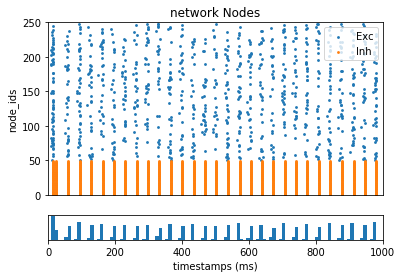

In [14]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

plot_raster(config_file='simulation_config.json', group_by='pop_name')

and the rates of each node

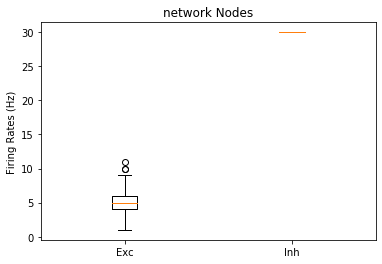

In [15]:
plot_rates_boxplot(config_file='simulation_config.json', group_by='pop_name')